# 感情分析v4

スコア取得を関数化

## ライブラリ

In [ ]:
# google colab向け
# !pip install japanize_matplotlib

In [40]:
import os
import sys
import glob
import shutil
import numpy as np
import math
from tqdm.notebook import tqdm
import pandas as pd
from pathlib import Path
import japanize_matplotlib
import matplotlib.pyplot as plt

In [2]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import pipeline
import torch
import torch.nn.functional as F

In [3]:
# Goole Colab環境か判断
# ローカル環境とColabo環境の両方で動作させたい(そのうち使う予定)
moduleList = sys.modules
ENV_COLAB = False
if 'google.colab' in moduleList:
    print("google_colab")
    ENV_COLAB = True
else:
    print("Not google_colab")
if ENV_COLAB:
    print("Execute in google_colab")

Not google_colab


## 関数定義

In [22]:
# スコア取得関数
"""
Arg:
    tokenizer
    model
    text: text(one line)
Returns:
    max logit
    max prediction
"""
def get_score(tokenizer, model, text):
    # 0: NEUTRAL  -> 0
    # 1: NEGATIVE -> -1
    # 2: POSITIVE -> 1
    coef_array = [0, -1, 1]
    # text: 文字列型を想定
    batch = tokenizer(text, padding=True, return_tensors='pt')

    with torch.no_grad():
        output = model(**batch)
        prediction = F.softmax(output.logits, dim=1)
        label = torch.max(output.logits, dim=1)
        value = label.values.item()
        index = label.indices.item()
    logit_value = value * coef_array[index]
    pred_value = torch.max(prediction).item() * coef_array[index]
    return logit_value, pred_value

In [23]:
# 小説のスコアを取得する関数
"""
Arg:
    file_path
Returns:
    data frame
"""
def get_novel_score(tokenizer, model, file_path):
    df = pd.read_csv(file_path)
    logit_score, pred_score = [], []
    for i, text in enumerate(tqdm(df['text'])):
        logit, pred = get_score(tokenizer, model, text)
        logit_score.append(logit)
        pred_score.append(pred)

    df['logit_score'] = logit_score
    df['pred_score'] = pred_score
    return df

In [24]:
# 指定されたwindowサイズで感情スコアの平均値を取得
def get_score_mean(scores, window_size=10, score_mean_num=100):
    score_mean = []
    slide = int((len(scores) - window_size - 1) / 99)
    for n in range(score_mean_num):
        start = slide * n
        if n == score_mean_num - 1:
            end = len(scores) - 1
        else:
            end = start + window_size
        score_mean.append(np.mean(scores[start:end]))
        # print(f'{n}:len(scores):{len(scores)},st:{start},ed:{end},{scores[end]}{np.array(scores)[-1]}')
    return score_mean

In [25]:
# スコアを0-1に規格化
def score_normalize(scores):
    return (scores - np.min(scores)) / (np.max(scores) - np.min(scores))

## モデル取得

In [9]:
tokenizer = AutoTokenizer.from_pretrained("koheiduck/bert-japanese-finetuned-sentiment")
model = AutoModelForSequenceClassification.from_pretrained("koheiduck/bert-japanese-finetuned-sentiment")

### 動作確認

In [10]:
# 動作確認
nlp = pipeline('sentiment-analysis',model=model,tokenizer=tokenizer)
print(nlp("私はとっても幸せ"))
print(nlp("私はとっても不幸"))

[{'label': 'POSITIVE', 'score': 0.9896088242530823}]
[{'label': 'NEGATIVE', 'score': 0.9918387532234192}]


## 小説のスコア取得

In [ ]:
target = pd.read_csv('data/target2.csv', index_col=0)
target.head(2)

In [ ]:
print(target.shape)
print(target[target['対象']].shape)

In [ ]:
for i, (_, row_data) in enumerate(target.iterrows()):
    try:
        print(f'{i}: {row_data["氏名"]} {row_data["作品名"]} {row_data["テキストファイルパス"]}')
        if row_data['対象'] and os.path.isfile(row_data['テキストファイルパス']):
            if not os.path.isfile(row_data['スコアファイルパス']):
                df = get_novel_score(tokenizer, model, row_data['テキストファイルパス'])
                df.to_csv(row_data['スコアファイルパス'])
        else:
            print('skip data')
    except Exception as e:
        print(e)

## 確認

エラーとなっているデータもあるが，ひとまず正常に取得できているデータについて確認してみる．

ここでは「夏目漱石」の作品で「文の数」が500以上のものに絞って感情曲線を表示してみる．

In [6]:
target = pd.read_csv('data/target2.csv', index_col=0)
soseki = target[target['氏名']=='夏目 漱石']
soseki.shape

(30, 14)

In [15]:
soseki = soseki[~np.isnan(soseki['length'])]
soseki = soseki[soseki['length'] >= 500]
soseki.shape

(17, 14)

In [19]:
soseki.head(2)

,対象,人物ID,氏名,読み,作品ID,作品名,副題,作品名読み,図書カードURL,テキストファイルURL,テキストファイルパス,スコアファイルパス,備考,length
2198,True,148,夏目 漱石,なつめ そうせき,769,薤露行,NaN,かいろこう,https://www.aozora.gr.jp/cards/000148/card769....,https://www.aozora.gr.jp/cards/000148/files/76...,./bunko/cards/000148/files/edit/769_ruby_565.txt,./bunko/cards/000148/files/score/769_ruby_565.txt,NaN,605.0
2201,True,148,夏目 漱石,なつめ そうせき,761,虞美人草,NaN,ぐびじんそう,https://www.aozora.gr.jp/cards/000148/card761....,https://www.aozora.gr.jp/cards/000148/files/76...,./bunko/cards/000148/files/edit/761_ruby_1861.txt,./bunko/cards/000148/files/score/761_ruby_1861...,NaN,9029.0


In [31]:
soseki_score = {}
for i, (_, data) in enumerate(soseki.iterrows()):
    if data['length'] > 500:
        print(data['氏名'], data['作品名'], data['スコアファイルパス'], data['length'])
        df = pd.read_csv(data['スコアファイルパス'])
        window_size = int(df.shape[0] / 5)
        logit_score_mean = get_score_mean(df['logit_score'], window_size=window_size)
        logit_score_norm = score_normalize(logit_score_mean)
        soseki_score[data['作品名']] = logit_score_norm

夏目 漱石 薤露行 ./bunko/cards/000148/files/score/769_ruby_565.txt 605.0
夏目 漱石 虞美人草 ./bunko/cards/000148/files/score/761_ruby_1861.txt 9029.0
夏目 漱石 坑夫 ./bunko/cards/000148/files/score/774_ruby_1640.txt 4836.0
夏目 漱石 こころ ./bunko/cards/000148/files/score/773_ruby_5968.txt 5168.0
夏目 漱石 琴のそら音 ./bunko/cards/000148/files/score/1073_ruby_4526.txt 653.0
夏目 漱石 趣味の遺伝 ./bunko/cards/000148/files/score/1104_ruby_4554.txt 1152.0
夏目 漱石 それから ./bunko/cards/000148/files/score/56143_ruby_50824.txt 6057.0
夏目 漱石 二百十日 ./bunko/cards/000148/files/score/751_ruby_1539.txt 1595.0
夏目 漱石 野分 ./bunko/cards/000148/files/score/791_ruby_1549.txt 3886.0
夏目 漱石 彼岸過迄 ./bunko/cards/000148/files/score/765_ruby_2469.txt 4705.0
夏目 漱石 坊っちゃん ./bunko/cards/000148/files/score/752_ruby_2438.txt 2720.0
夏目 漱石 幻影の盾 ./bunko/cards/000148/files/score/780_ruby_569.txt 667.0
夏目 漱石 道草 ./bunko/cards/000148/files/score/783_ruby_1311.txt 5137.0
夏目 漱石 明暗 ./bunko/cards/000148/files/score/782_ruby_2315.txt 11432.0
夏目 漱石 門 ./bunko/cards/000148/files/score

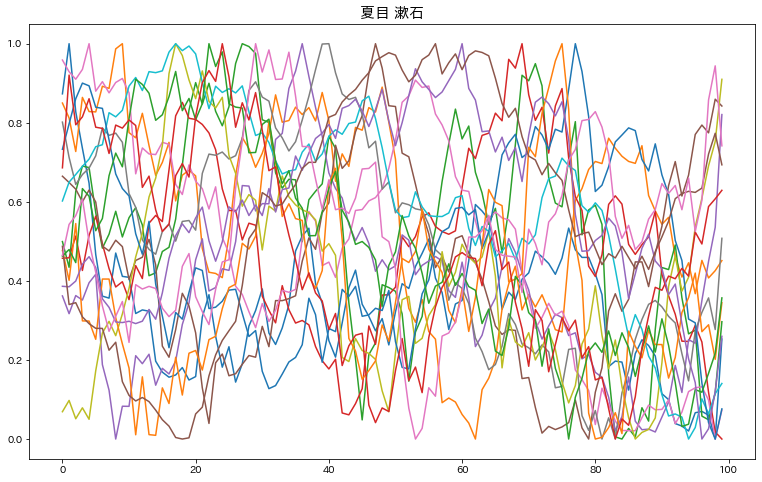

In [43]:
fig = plt.figure(figsize=(13, 8))
ax = fig.add_subplot(111)
ax.set_title('夏目 漱石', size=15)
for key in soseki_score:
    ax.plot(soseki_score[key])
plt.show()

抽象画みたいになった．

関数化して他の作家も見てみる．

In [55]:
def get_wirter_score(list_path, writer, line_num=500):
    list = pd.read_csv(list_path, index_col=0)
    target = list[list['氏名'] == writer] # 指定された作家
    target = target[~np.isnan(target['length'])] # 欠損データは対象外
    target = target[target['length'] >= line_num] # 文の総数がline_num以上
    
    target_score = {}
    for i, (_, data) in enumerate(target.iterrows()):
        # print(data['氏名'], data['作品名'], data['スコアファイルパス'], data['length'])
        df = pd.read_csv(data['スコアファイルパス'])
        window_size = int(df.shape[0] / 5)
        logit_score_mean = get_score_mean(df['logit_score'], window_size=window_size)
        logit_score_norm = score_normalize(logit_score_mean)
        target_score[data['作品名']] = logit_score_norm
    
    return target_score

In [49]:
def show_writer_score(writer, score):
    fig = plt.figure(figsize=(13, 8))
    ax = fig.add_subplot(111)
    ax.set_title(writer, size=15)
    for key in score:
        ax.plot(score[key])
    plt.show()

In [51]:
TARGET_PATH = 'data/target2.csv'

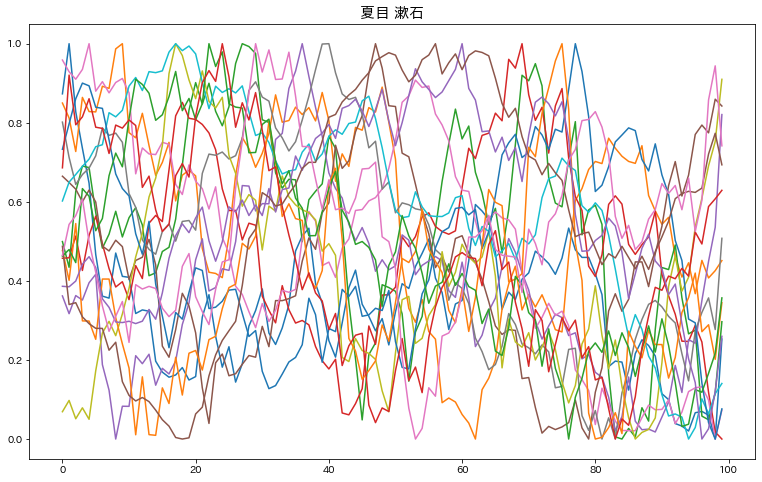

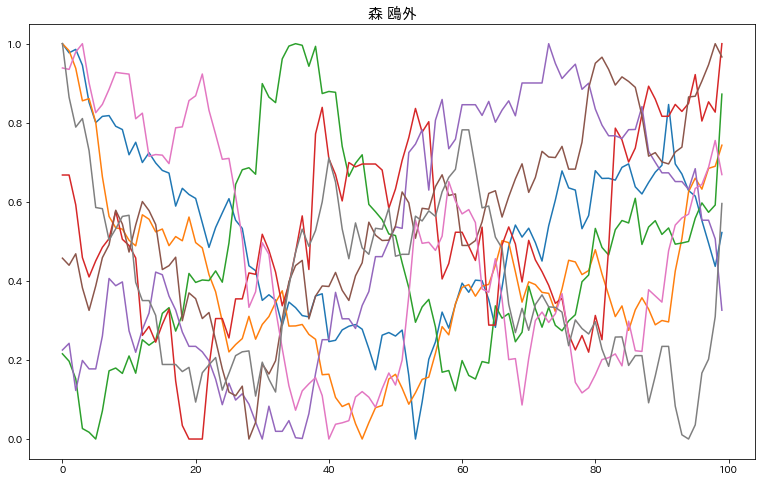

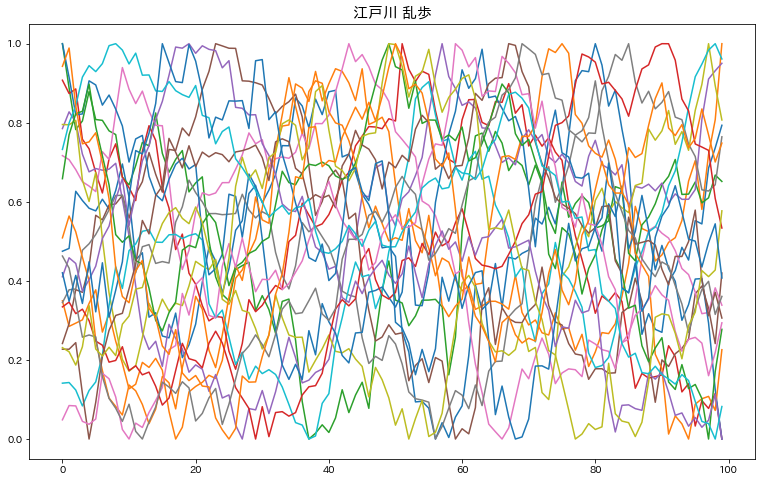

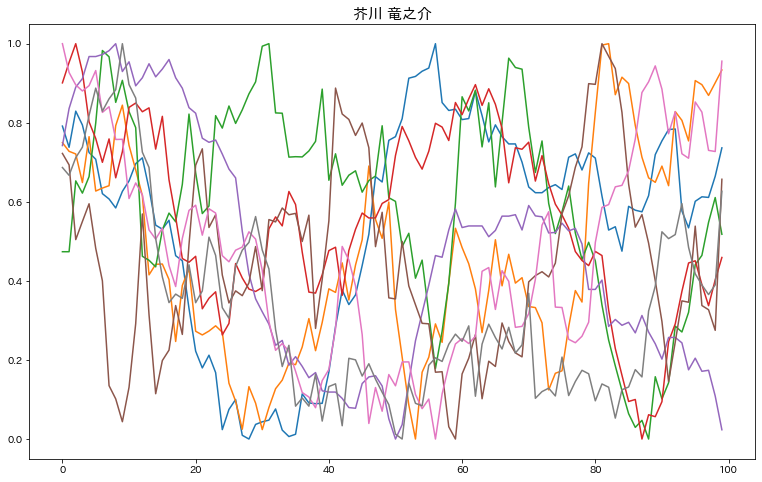

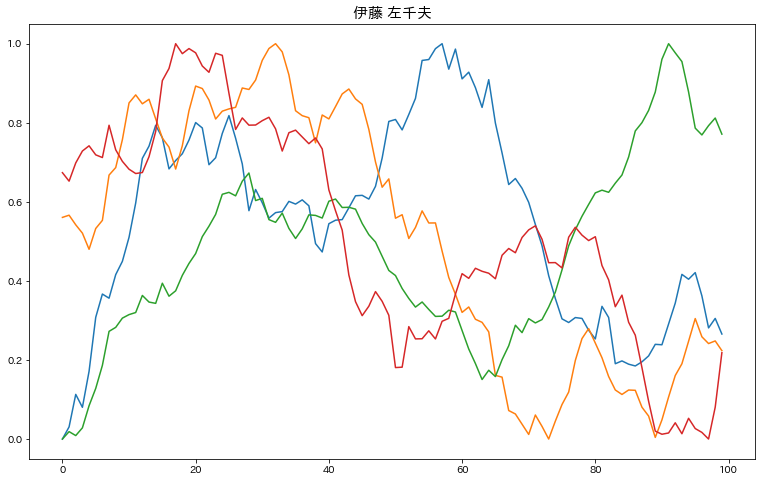

In [63]:
writer_list = ['夏目 漱石', '森 鴎外', '江戸川 乱歩', '芥川 竜之介', '伊藤 左千夫']
for writer in writer_list:
    writer_score = get_wirter_score(TARGET_PATH, writer)
    show_writer_score(writer, writer_score)